In [1]:
import configparser
import glob
import os
import pickle

#from gensim.models import KeyedVectors, TranslationMatrix
import numpy as np
import pandas as pd
import sktensor
import sparse
import tensorly as tl

from eval_tensor import VerbTensorEvaluator

import matplotlib.pyplot as plt
%pylab inline

import logging
logging.basicConfig(level=logging.INFO, 
                    format='%(msecs)d %(levelname)-8s [%(lineno)d] %(message)s')

Populating the interactive namespace from numpy and matplotlib


/home/makrai/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
config = configparser.ConfigParser()                                            
config.read('config.ini')                                                       

['config.ini']

# Sparsity

In [ ]:
evalor = VerbTensorEvaluator(non_negative=True, weight='npmi', include_empty=False, cutoff=1000000, rank=64)
evalor.load_embeddings()
tensor = evalor.decomped_tns
core = tensor.core
tensor.shape

In [ ]:
core.shape

In [4]:
height = 8
#pylab.rcParams['figure.figsize'] = (2*height, height)

plt.matshow(tensor.factors[1][:40])
plt.colorbar()
#plt.savefig('/home/makrai/repo/paper/Coling2020/verbtensor/img/nonneg-mx.png')

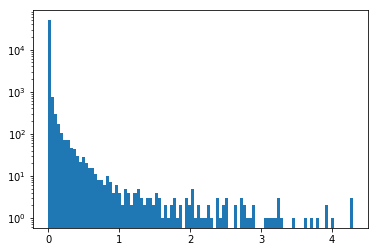

In [12]:
_ = plt.hist(np.sort(tensor.factors[1].reshape(-1))[:-10], log=True, bins=100)
#plt.savefig('/home/makrai/repo/paper/MSZNY22/verbtensor/img/nonneg-histg.png')

# Shape by cutoff

In [17]:
def get_cufott_and_shape():
    for filen in glob.glob('/mnt/permanent/home/makrai/project/verb-tensor/nonempty/tensor/sparstensr_*'):
        non_empty = 'non-empty' in filen
        cutoff = os.path.splitext(os.path.basename(filen))[0].split('_')[-1]
        tensor, _ =  pickle.load(open(filen, mode='rb'))
        yield non_empty, cutoff, tensor.shape

In [ ]:
df = pd.DataFrame(get_cufott_and_shape())

In [22]:
df.columns=['non_empty', 'cutoff', 'shape']

In [28]:
df.cutoff = df.cutoff.astype(int)

In [46]:
df = df.sort_values(list(df.columns)).drop_duplicates().set_index('cutoff')

In [53]:
df = df[df.non_empty==True].join(df[df.non_empty==False], lsuffix=' without emtpy', rsuffix=' with emtpy')

In [65]:
print(df.loc[df.isna().sum(axis=1)==0,['shape with emtpy', 'shape without emtpy']].to_latex())

\begin{tabular}{lll}
\toprule
{} &         shape with emtpy &      shape without emtpy \\
cutoff   &                          &                          \\
\midrule
1        &  (324196, 90606, 287967) &  (206488, 41075, 188619) \\
10       &  (160629, 37427, 129694) &   (109432, 19824, 92635) \\
100      &    (92999, 20937, 69536) &    (71768, 13907, 57420) \\
1000     &    (44168, 10444, 32359) &     (40309, 8838, 30280) \\
10000    &     (13765, 5070, 12313) &     (13610, 4895, 12115) \\
30000    &       (7395, 3568, 7524) &       (7349, 3526, 7460) \\
50000    &       (5438, 2994, 5881) &       (5411, 2976, 5843) \\
100000   &       (3474, 2313, 4120) &       (3463, 2308, 4108) \\
300000   &       (1515, 1438, 2200) &       (1512, 1438, 2197) \\
1000000  &          (546, 814, 981) &          (545, 813, 980) \\
3000000  &          (168, 461, 399) &          (167, 461, 398) \\
10000000 &            (36, 194, 87) &            (35, 194, 86) \\
\bottomrule
\end{tabular}



# Latent dims

In [3]:
mode_names = ['nsubj', 'ROOT', 'dobj']

def show_latent(evalor, latent_i, mode_i):
    surf_indices = evalor.decomped_tns.factors[mode_i][:,latent_i]
    if isinstance(surf_indices, sparse.COO):
        surf_indices = surf_indices.todense()
    surf_indices = np.argsort(-surf_indices)
    return latent_i, ', '.join([evalor.index[mode_names[mode_i]].inv[surf_i] for surf_i in surf_indices])

In [10]:
def enum_latent(non_negative=True, decomp_algo='parafac', k_to_show=4):
    records = []
    if decomp_algo == 'parafac':
        if non_negative:
            evalor = VerbTensorEvaluator(non_negative=non_negative)
        else:
            evalor = VerbTensorEvaluator(non_negative=non_negative, decomp_algo=decomp_algo, 
                                         weight='npmi', include_empty=False, cutoff=300000, rank=256)
        evalor.load_embeddings()
        indices = [(i,i,i) for i in  range(k_to_show)]
    else:
        if non_negative:
            evalor = VerbTensorEvaluator(non_negative=non_negative, decomp_algo=decomp_algo,
                                         weight='npmi', include_empty=False, cutoff=1000000, rank=64)
        else:
            evalor = VerbTensorEvaluator(non_negative=non_negative, decomp_algo=decomp_algo,
                                         weight='npmi', include_empty=True, cutoff=100000, rank=64)            
        evalor.load_embeddings()
        core = evalor.decomped_tns.core
        indices = zip(*np.unravel_index(np.argsort(-core.reshape(-1))[:k_to_show], core.shape))
    for i, j, k in indices:
        records.append(show_latent(evalor, i, 0))
        records.append(show_latent(evalor, j, 1))
        records.append(show_latent(evalor, k, 2))
    print(pd.DataFrame(records, columns=['dim', 'words']).set_index('dim').to_latex())

In [5]:
pd.set_option('lw', 90)

In [8]:
enum_latent()

\begin{tabular}{ll}
\toprule
{} &                                                                                      words \\
dim &                                                                                            \\
\midrule
0   &  , that, which, it, story, he, they, who, what, one, she, work, event, -rrb-, this, you... \\
0   &  catch, attract, draw, pay, deserve, capture, gain, grab, get, receive, focus, require,... \\
0   &  attention, eye, crowd, interest, fire, visitor, audience, conclusion, breath, people, ... \\
1   &  , who, we, he, I, you, she, they, -rrb-, student, member, people, group, Center, parti... \\
1   &  attend, host, hold, organize, schedule, enjoy, join, arrange, cancel, miss, watch, pla... \\
1   &  meeting, event, conference, session, party, show, school, class, dinner, church, tour,... \\
2   &  that, which, it, this, , change, factor, they, choice, condition, decision, issue, -rr... \\
2   &  affect, impact, influence, improve, hurt, reflect, benef

In [11]:
enum_latent(decomp_algo='tucker')

\begin{tabular}{ll}
\toprule
{} &                                                                                      words \\
dim &                                                                                            \\
\midrule
5   &  court, Court, judge, panel, official, we, he, it, authority, government, -rrb-, Board,... \\
10  &  reject, dismiss, deny, grant, hear, consider, decide, accept, throw, resolve, sustain,... \\
7   &  motion, appeal, claim, request, argument, case, challenge, application, complaint, att... \\
4   &  revenue, sale, share, price, stock, production, cost, rate, order, volume, number, fut... \\
3   &  rise, fall, increase, jump, drop, decline, climb, decrease, grow, gain, slip, represen... \\
1   &  percent, \%, \$, increase, point, most, rate, level, average, less, matter, value, cost,... \\
11  &  hotel, property, room, restaurant, home, Center, house, location, facility, House, are... \\
8   &  offer, boast, feature, have, provide, include, enjoy, 

In [75]:
enum_latent(decomp_algo='parafac', non_negative=False)

\begin{tabular}{ll}
\toprule
{} &                                                                                      words \\
dim &                                                                                            \\
\midrule
0   &  Israel, group, government, Foundation, Association, company, -rrb-, military, army, Cl... \\
0   &  launch, wage, suspend, mount, begin, run, fund, organize, sponsor, administer, carry, ... \\
0   &  campaign, attack, program, initiative, operation, strike, programme, website, effort, ... \\
1   &  user, you, application, customer, developer, visitor, client, processor, device, User,... \\
1   &  access, select, specify, upload, view, enter, edit, browse, click, create, retrieve, m... \\
1   &  file, datum, content, document, page, parameter, site, folder, node, Internet, informa... \\
2   &  device, assembly, means, structure, system, element, plate, section, interface, unit, ... \\
2   &  comprise, include, contain, have, utilize, employ, repre

In [12]:
enum_latent(decomp_algo='tucker', non_negative=False)

\begin{tabular}{ll}
\toprule
{} &                                                                                      words \\
dim &                                                                                            \\
\midrule
0   &  , that, we, you, they, he, I, who, which, it, she, -rrb-, this, company, people, stude... \\
0   &  have, include, provide, use, create, bring, give, support, produce, regard, put, offer... \\
0   &  , they, system, it, number, the, program, area, he, information, datum, value, process... \\
1   &  , Benefiting, MagicSearch, incase, LOOMIS, Knetbooks, ATOL, Woot, para, BabyCenter, Li... \\
1   &  have, provide, offer, create, use, include, give, contain, regard, enhance, maintain, ... \\
1   &  , what, percent, \%, that, \$, point, which, I, way, game, -rsb-, who, increase, more, c... \\
0   &  , that, we, you, they, he, I, who, which, it, she, -rrb-, this, company, people, stude... \\
4   &  have, tell, ask, kill, inform, meet, convince, assist,

In [16]:
records = []
for i in range(6,16):
    records.append(show_latent(i, 0))
print(pd.DataFrame(records, columns=['dim', 'subjects']).set_index('dim').to_latex())

\begin{tabular}{ll}
\toprule
{} &                                           subjects \\
dim &                                                    \\
\midrule
6   &  board, Council, Board, Commission, Committee, ... \\
7   &  study, result, analysis, finding, datum, resea... \\
8   &  -rsb-, -lsb-, reference, effect, role, cell, e... \\
9   &  Department, police, Center, official, -rrb-, d... \\
10  &  article, paper, report, section, study, course... \\
11  &  hotel, property, room, restaurant, home, Cente... \\
12  &  factor, condition, comment, activity, choice, ... \\
13  &  paper, author, course, company, scientist, res... \\
14  &  course, program, plan, applicant, student, sol... \\
15  &  event, year, band, show, couple, Inc., Center,... \\
\bottomrule
\end{tabular}



In [17]:
records = []
for i in range(10):
    records.append(show_latent(i, 1))
print(pd.DataFrame(records, columns=['dim', 'verbs']).set_index('dim').to_latex())

\begin{tabular}{ll}
\toprule
{} &                                              verbs \\
dim &                                                    \\
\midrule
0   &  include, provide, illustrate, show, feature, c... \\
1   &  illustrate, show, depict, represent, comprise,... \\
2   &  approve, adopt, reject, pass, consider, review... \\
3   &  rise, fall, increase, jump, drop, decline, cli... \\
4   &  provide, present, give, include, describe, rev... \\
5   &  -lsb-\_VBD, -lsb-\_VBP, quote, -lsb-\_VB, /, rese... \\
6   &  issue, release, publish, receive, prepare, sub... \\
7   &  exceed, represent, reflect, match, reach, aver... \\
8   &  offer, boast, feature, have, provide, include,... \\
9   &  present, describe, examine, propose, explore, ... \\
\bottomrule
\end{tabular}



In [18]:
records = []
for i in range(10):
    records.append(show_latent(i, 2))
print(pd.DataFrame(records, columns=['dim', 'objects']).set_index('dim').to_latex())

\begin{tabular}{ll}
\toprule
{} &                                            objects \\
dim &                                                    \\
\midrule
0   &  example, view, structure, configuration, chart... \\
1   &  percent, \%, \$, increase, point, most, rate, le... \\
2   &  resolution, request, budget, plan, proposal, c... \\
3   &  -rsb-, column, 1, 4, 5, 3, debut, 2, detail, r... \\
4   &  -rsb-, device, module, unit, portion, pluralit... \\
5   &  suit, complaint, motion, appeal, report, notic... \\
6   &  \$, dollar, more, million, less, increase, hund... \\
7   &  motion, appeal, claim, request, argument, case... \\
8   &  overview, approach, analysis, method, finding,... \\
9   &  room, pool, accommodation, access, facility, r... \\
\bottomrule
\end{tabular}



## Athlete ... race

In [ ]:
embed = KeyedVectors(64)

In [ ]:
embed.add_vectors(list(evalor.index['ROOT'].inv.values()), tensor.factors[1])

In [ ]:
def predict_verb(subj='athlete', obj='race'):
    tensor1 = tensor.core
    tensor1 = tl.tenalg.mode_dot(tensor1, evalor.lookup(subj, 0), 0)
    tensor1 = tl.tenalg.mode_dot(tensor1, evalor.lookup(obj, 2), 1)
    return embed.most_similar([tensor1])

In [ ]:
predict_verb()

In [ ]:
predict_verb(subj='user', obj='command')

In [ ]:
tensor.factors[0].shape

# Parafac

In [ ]:
tensor_dir = config['DEFAULT']['ProjectDirectory']+'tensor/'
evalor = VerbTensorEvaluator(cutoff=50000, rank=256, weight='npmi', decomp_algo='parafac')
modes = ['nsubj', 'ROOT', 'dobj']

In [ ]:
evalor.load_embeddings()

In [ ]:
_ = plt.hist(np.sort(evalor.decomped_tns.factors[1].reshape(-1).todense())[:-10], log=True, bins=100)
plt.savefig('/home/makrai/repo/paper/CONLL21//verbtensor/img/posibneg-histg.png')

In [ ]:
evalor.decomped_tns.weights.todense()

In [ ]:
i_word = [{i: w for w, i in evalor.index[j].items()} for j in modes]
vocab = [np.array([i_word[j][i] for i in range(len(i_word[j]))]) for j in range(len(i_word))]
for k, j in enumerate(
        #np.argsort(-ktensor.lmbda)[:4]):#
        range(evalor.decomped_tns.rank)):
    print(f'\n{k}')# {j}')
    for i, factor in enumerate(evalor.decomped_tns.factors):
        ids = np.argsort(factor[:,j].todense())[:7]
        print(vocab[i][ids])
        #print(['{:.1g}'.format(coord) for coord in ktensor.U[i][ids,j]])

|rank|$\lambda$|e.g.|
|----|---------|----|
|16|1|topic/example (2) provide/offer (2) assistance/guidance|
|32|1|Android (3)  win degree (1)|
|64|1|I describe (1) game/story (2)|